# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np

class Node:
    # 该类为所有其他图节点类的父类
    def __init__(self, inputs=[]):
        #定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        #每个节点都是其输入节点的输出节点
        for n in self.inputs:
            # 把自身加入到输入节点的输出节点列表中
            n.outputs.append(self)

        self.value = None
        
        self.gradients = {}
        # 梯度是dict形式，key是input节点，value是输入节点对这个节点的偏导
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented
        
class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        #定义节点数值
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            #以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        # 把它所有input的value值累加
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        #前向 即为sigmoid函数计算
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        #反向传播计算梯度
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []

In [3]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 2000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 132.308
Epoch: 101, Loss: 6.737
Epoch: 201, Loss: 6.032
Epoch: 301, Loss: 5.096
Epoch: 401, Loss: 4.349
Epoch: 501, Loss: 4.989
Epoch: 601, Loss: 4.041
Epoch: 701, Loss: 3.290
Epoch: 801, Loss: 3.317
Epoch: 901, Loss: 3.427
Epoch: 1001, Loss: 3.665
Epoch: 1101, Loss: 3.305
Epoch: 1201, Loss: 3.468
Epoch: 1301, Loss: 3.025
Epoch: 1401, Loss: 3.153
Epoch: 1501, Loss: 3.058
Epoch: 1601, Loss: 3.143
Epoch: 1701, Loss: 3.563
Epoch: 1801, Loss: 2.785
Epoch: 1901, Loss: 3.490


In [4]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [5]:
forward(l2,graph)

array([[22.84597206],
       [23.38372329],
       [29.83587353],
       [21.6152016 ],
       [15.29049743],
       [19.10201608],
       [23.36596846],
       [29.19298091],
       [29.19298091],
       [23.01129639],
       [31.10102438],
       [50.76809897],
       [18.59359116],
       [28.096956  ],
       [20.11631233],
       [20.02723679]])

In [6]:
import matplotlib.pyplot as plt

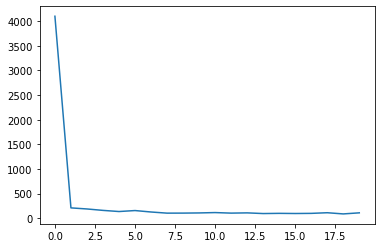

In [7]:
plt.plot(range(len(losses)), losses)

In [8]:
losses

[4101.541552062237,
 208.84346694378902,
 186.98000913669335,
 157.98924729368218,
 134.8285091403252,
 154.64738715158904,
 125.2779636082419,
 101.98124670654518,
 102.8139058604992,
 106.23306191722028,
 113.62453480063839,
 102.45364193900079,
 107.49983936739392,
 93.7695926423976,
 97.74359417488394,
 94.78876384235208,
 97.42155143900355,
 110.44911623609458,
 86.32852233215338,
 108.20339602008931]

In [9]:
W2.value

array([[ 6.74575884],
       [12.68728052],
       [ 5.39541491],
       [ 5.7213527 ],
       [ 7.04946485],
       [ 7.68613884],
       [10.22213898],
       [-9.40173312],
       [ 5.55930856],
       [ 9.12933038]])

In [10]:
X_ = data['data']
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [11]:
import keras

Using TensorFlow backend.


In [15]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='relu', input_dim=13))
model.add(Dense(units=30, activation='relu', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [16]:
history = model.fit(X_, y_, epochs=500, batch_size=32)

Epoch 1/500
506/506 [==============================] - 0s 359us/step - loss: 403.4494 - mse: 403.4494
Epoch 2/500
506/506 [==============================] - 0s 109us/step - loss: 115.4834 - mse: 115.4835
Epoch 3/500
506/506 [==============================] - 0s 124us/step - loss: 50.0369 - mse: 50.0369
Epoch 4/500
506/506 [==============================] - 0s 117us/step - loss: 33.7663 - mse: 33.7663
Epoch 5/500
506/506 [==============================] - 0s 101us/step - loss: 30.0563 - mse: 30.0563
Epoch 6/500
506/506 [==============================] - 0s 104us/step - loss: 21.0638 - mse: 21.0638
Epoch 7/500
506/506 [==============================] - 0s 102us/step - loss: 26.4041 - mse: 26.4040
Epoch 8/500
506/506 [==============================] - 0s 108us/step - loss: 16.1903 - mse: 16.1903
Epoch 9/500
506/506 [==============================] - 0s 121us/step - loss: 21.0512 - mse: 21.0512
Epoch 10/500
506/506 [==============================] - 0s 137us/step - loss: 12.5404 - mse: 12.

506/506 [==============================] - 0s 97us/step - loss: 4.1255 - mse: 4.1255
Epoch 84/500
506/506 [==============================] - 0s 99us/step - loss: 3.8221 - mse: 3.8221
Epoch 85/500
506/506 [==============================] - 0s 120us/step - loss: 3.7960 - mse: 3.7960
Epoch 86/500
506/506 [==============================] - 0s 100us/step - loss: 3.2510 - mse: 3.2510
Epoch 87/500
506/506 [==============================] - 0s 101us/step - loss: 4.1063 - mse: 4.1063
Epoch 88/500
506/506 [==============================] - 0s 102us/step - loss: 4.1776 - mse: 4.1776
Epoch 89/500
506/506 [==============================] - 0s 97us/step - loss: 3.5056 - mse: 3.5056
Epoch 90/500
506/506 [==============================] - 0s 88us/step - loss: 3.4145 - mse: 3.4145
Epoch 91/500
506/506 [==============================] - 0s 91us/step - loss: 3.4333 - mse: 3.4333
Epoch 92/500
506/506 [==============================] - 0s 83us/step - loss: 3.0657 - mse: 3.0657
Epoch 93/500
506/506 [=======

506/506 [==============================] - 0s 122us/step - loss: 2.1381 - mse: 2.1381
Epoch 166/500
506/506 [==============================] - 0s 114us/step - loss: 2.1210 - mse: 2.1210
Epoch 167/500
506/506 [==============================] - 0s 117us/step - loss: 1.7555 - mse: 1.7555
Epoch 168/500
506/506 [==============================] - 0s 118us/step - loss: 2.6095 - mse: 2.6095
Epoch 169/500
506/506 [==============================] - 0s 122us/step - loss: 3.9393 - mse: 3.9393
Epoch 170/500
506/506 [==============================] - 0s 112us/step - loss: 2.9658 - mse: 2.9658
Epoch 171/500
506/506 [==============================] - 0s 124us/step - loss: 2.5025 - mse: 2.5025
Epoch 172/500
506/506 [==============================] - 0s 93us/step - loss: 2.4602 - mse: 2.4602
Epoch 173/500
506/506 [==============================] - 0s 108us/step - loss: 1.8768 - mse: 1.8768
Epoch 174/500
506/506 [==============================] - 0s 95us/step - loss: 2.4825 - mse: 2.4825
Epoch 175/500
50

506/506 [==============================] - 0s 99us/step - loss: 1.8753 - mse: 1.8753
Epoch 248/500
506/506 [==============================] - 0s 102us/step - loss: 1.6665 - mse: 1.6665
Epoch 249/500
506/506 [==============================] - 0s 91us/step - loss: 1.5830 - mse: 1.5830
Epoch 250/500
506/506 [==============================] - 0s 98us/step - loss: 1.8725 - mse: 1.8725
Epoch 251/500
506/506 [==============================] - 0s 101us/step - loss: 1.6905 - mse: 1.6905
Epoch 252/500
506/506 [==============================] - 0s 106us/step - loss: 3.4088 - mse: 3.4088
Epoch 253/500
506/506 [==============================] - 0s 106us/step - loss: 1.7967 - mse: 1.7967
Epoch 254/500
506/506 [==============================] - 0s 112us/step - loss: 1.9930 - mse: 1.9930
Epoch 255/500
506/506 [==============================] - 0s 143us/step - loss: 1.5236 - mse: 1.5236
Epoch 256/500
506/506 [==============================] - 0s 171us/step - loss: 1.5123 - mse: 1.5123
Epoch 257/500
506

506/506 [==============================] - 0s 114us/step - loss: 1.9149 - mse: 1.9149
Epoch 330/500
506/506 [==============================] - 0s 138us/step - loss: 1.3519 - mse: 1.3519
Epoch 331/500
506/506 [==============================] - 0s 126us/step - loss: 1.5907 - mse: 1.5907
Epoch 332/500
506/506 [==============================] - 0s 154us/step - loss: 2.0857 - mse: 2.0857
Epoch 333/500
506/506 [==============================] - 0s 172us/step - loss: 1.7567 - mse: 1.7567
Epoch 334/500
506/506 [==============================] - 0s 180us/step - loss: 1.4155 - mse: 1.4155
Epoch 335/500
506/506 [==============================] - 0s 134us/step - loss: 1.5887 - mse: 1.5887
Epoch 336/500
506/506 [==============================] - 0s 110us/step - loss: 1.3582 - mse: 1.3582
Epoch 337/500
506/506 [==============================] - 0s 110us/step - loss: 1.3093 - mse: 1.3093
Epoch 338/500
506/506 [==============================] - 0s 103us/step - loss: 1.9795 - mse: 1.9795
Epoch 339/500


506/506 [==============================] - 0s 139us/step - loss: 1.0207 - mse: 1.0207
Epoch 412/500
506/506 [==============================] - 0s 140us/step - loss: 1.4893 - mse: 1.4893
Epoch 413/500
506/506 [==============================] - 0s 171us/step - loss: 1.1440 - mse: 1.1440
Epoch 414/500
506/506 [==============================] - 0s 130us/step - loss: 1.0070 - mse: 1.0070
Epoch 415/500
506/506 [==============================] - 0s 132us/step - loss: 1.0649 - mse: 1.0649
Epoch 416/500
506/506 [==============================] - 0s 130us/step - loss: 0.9619 - mse: 0.9619
Epoch 417/500
506/506 [==============================] - 0s 128us/step - loss: 1.0879 - mse: 1.0879
Epoch 418/500
506/506 [==============================] - 0s 138us/step - loss: 1.0233 - mse: 1.0233
Epoch 419/500
506/506 [==============================] - 0s 131us/step - loss: 1.0402 - mse: 1.0402
Epoch 420/500
506/506 [==============================] - 0s 122us/step - loss: 1.0081 - mse: 1.0081
Epoch 421/500


506/506 [==============================] - 0s 113us/step - loss: 0.6595 - mse: 0.6595
Epoch 494/500
506/506 [==============================] - 0s 109us/step - loss: 1.4131 - mse: 1.4131
Epoch 495/500
506/506 [==============================] - 0s 150us/step - loss: 1.4390 - mse: 1.4390
Epoch 496/500
506/506 [==============================] - 0s 185us/step - loss: 1.3222 - mse: 1.3222
Epoch 497/500
506/506 [==============================] - 0s 105us/step - loss: 1.1097 - mse: 1.1097
Epoch 498/500
506/506 [==============================] - 0s 108us/step - loss: 0.8973 - mse: 0.8973
Epoch 499/500
506/506 [==============================] - 0s 148us/step - loss: 0.7656 - mse: 0.7656
Epoch 500/500
506/506 [==============================] - 0s 157us/step - loss: 1.1343 - mse: 1.1343


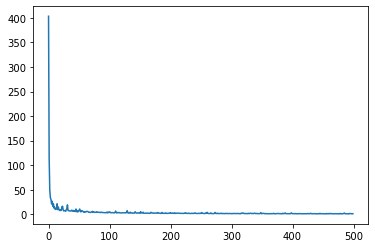

In [17]:
plt.plot(history.history['loss'])

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

一个神经元是一个线性函数 y=Wx+b, 后面可能还跟着一个激活函数。

####  2. Why we use non-linear activation funcitons in neural networks?

1.如果没有引入非线性激活函数，全是线性函数，那么无论多少层神经网络，都能化简为一层神经网络。  
2.世界是复杂的，不是纯线性函数就可以拟合的，比如引入非线性函数，才可以更好地拟合复杂的世界。

#### 3. What is the 'Logistic Loss' ?

Logitstic Loss是Cross Entropy Loss在二分类场景中的特例。  
loss = -(ylog(y^) + (1-y)log(1-y^))

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

推荐使用sigmoid激活函数。sigmoid的取值范围是[0,1]，比较符合二分类场景。  
relu范围是[0, +∞],leaky relu也是从0附近到+∞。  
tanh范围是[-1,1].  
相比之下，sigmoid最适合二分类。

#### 5. Why we don't use zero initialization for all parameters ?

神经网络具有对称性。如果初始化全0，那么在这样的对称性结构下，反向传播/梯度下降计算后，相同层的多个神经元参数会相同，模型难以收敛。

#### 6. Can you implement the softmax function using python ? 

In [18]:
import numpy as np

def softmax(y_input):
    # 行为种类，每列为一个样本标签
    temp = np.exp(y_input)
    return temp/np.sum(temp, axis=0)

In [19]:
softmax([[1,2,3,4], [5,5,5,5]])

array([[0.01798621, 0.04742587, 0.11920292, 0.26894142],
       [0.98201379, 0.95257413, 0.88079708, 0.73105858]])

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [20]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [21]:
# Loading the data 
digits = datasets.load_digits()

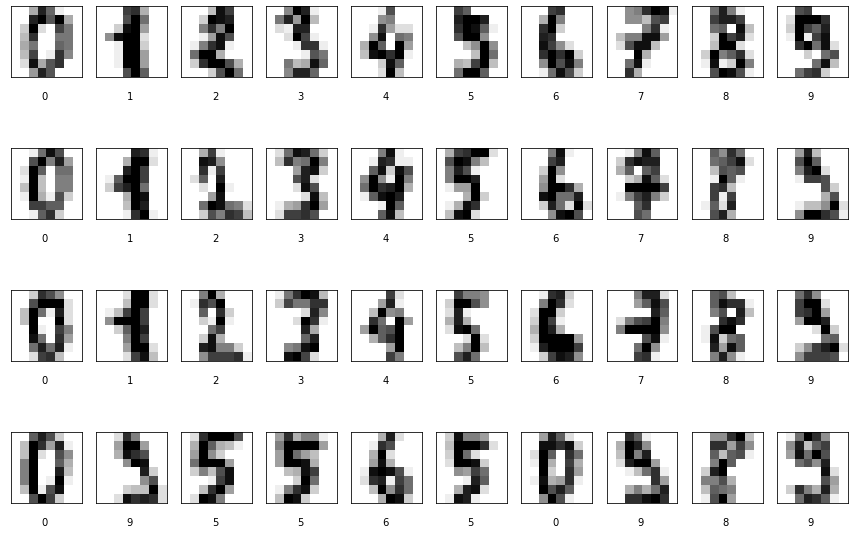

In [22]:
# Vilizating the data
plt.figure(figsize=(15,10))
for i in range(1,41):
    plt.subplot(4,10,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [23]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [24]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

## 直接用sklearn内部的逻辑斯蒂回归函数计算

In [26]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\myx\Anaconda3\envs\tf2.0\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
y_pre = lr.predict(X_test)
y_pre

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [28]:
# 计算预测的正确率
np.mean(y_pre == y_test)

0.8955555555555555

In [29]:
# 用自带的函数计算预测正确率
lr.score(X_test, y_test)

0.8955555555555555

## 使用sklearn的神经网络模型计算

In [30]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(10, 2), random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [31]:
# 计算正确率
clf.score(X_test, y_test)

0.9555555555555556

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [32]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1 / (1 + np.exp(-z))
    return s

In [33]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))
print("sigmoid([[0,2], [0,2]]) = " + str(sigmoid(np.array([[0,2], [0,2]]))))

sigmoid([0,2]) = [0.5        0.88079708]
sigmoid([[0,2], [0,2]]) = [[0.5        0.88079708]
 [0.5        0.88079708]]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [34]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.random((dim,1))
    b = 0

    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [35]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    temp = Y * np.log(A) + (1 - Y) * np.log(1 - A)

    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A), axis=1)
    
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y, axis=1)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [36]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    batch_size = 50
    for j in range(num_iterations):
        costs = []
        for i in range(0, X.shape[1], batch_size):
            X_ = X[:,i:i+batch_size]
            Y_ = Y[:,i:i+batch_size]

            grads, cost = propagate(w,b,X_,Y_)

            dw = grads['dw']
            db = grads['db']

            w -= learning_rate * dw
            b -= learning_rate * db

            costs.append(cost)
        
        cost = sum(costs)/len(costs)
        if print_cost and j % 100 == 0:
            print ("Cost after iteration %i: %f" %(j, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
     
    return params, grads, cost

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [37]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0,i] = 0 if A[0,i] <= 0.5 else 1
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [38]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
#     # X标准化处理
#     X_train /= X_train.max()
#     X_test /= X_train.max()
#     # XY参数格式调整
#     X_train = X_train.T
#     Y_train = np.expand_dims(Y_train, axis=0)
#     X_test = X_test.T
#     Y_test = np.expand_dims(Y_test, axis=0)
    
    # 参数初始化
    w, b = initialize_parameters(X_train.shape[0])
    
    # 训练模型
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
            
    # 训练集精度
    Y_train_ = predict(w, b, X_train)
    traing_accuracy = np.mean(Y_train_ == Y_train)
           
    # 测试集
    Y_pre = predict(w, b, X_test)
    test_accuracy = np.mean(Y_pre == Y_test)
    
    d = {"w":w,
         "b":b,
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    
    return d

In [39]:
# 获取数据
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

# 数据预处理
# X标准化处理
X_train /= X_train.max()
X_test /= X_train.max()
# XY参数格式调整
X_train = X_train.T
y_train = np.expand_dims(y_train, axis=0)
X_test = X_test.T
y_test = np.expand_dims(y_test, axis=0)

In [40]:
d = model(X_train, y_train, X_test, y_test, 5000, 1e-1, True)
print(d)

Cost after iteration 0: 2.038772
Cost after iteration 100: 0.281880
Cost after iteration 200: 0.263894
Cost after iteration 300: 0.257891
Cost after iteration 400: 0.255150
Cost after iteration 500: 0.253671
Cost after iteration 600: 0.252778
Cost after iteration 700: 0.252191
Cost after iteration 800: 0.251779
Cost after iteration 900: 0.251472
Cost after iteration 1000: 0.251235
Cost after iteration 1100: 0.251043
Cost after iteration 1200: 0.250884
Cost after iteration 1300: 0.250747
Cost after iteration 1400: 0.250628
Cost after iteration 1500: 0.250522
Cost after iteration 1600: 0.250427
Cost after iteration 1700: 0.250339
Cost after iteration 1800: 0.250257
Cost after iteration 1900: 0.250181
Cost after iteration 2000: 0.250110
Cost after iteration 2100: 0.250042
Cost after iteration 2200: 0.249977
Cost after iteration 2300: 0.249915
Cost after iteration 2400: 0.249856
Cost after iteration 2500: 0.249799
Cost after iteration 2600: 0.249744
Cost after iteration 2700: 0.249691
Cost

In [41]:
y_pre = predict(d['w'], d['b'], X_test)
y_pre

array([[1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

学习率越大，学习进度越快。即同样的训练轮次，学习率大的loss值小。

0.0005
0.001
0.0015
0.002
0.0025
0.003
0.0035
0.004
0.0045000000000000005
0.005000000000000001
0.0055
0.006
0.006500000000000001
0.007000000000000001
0.0075
0.008
0.0085
0.009000000000000001
0.009500000000000001
0.01


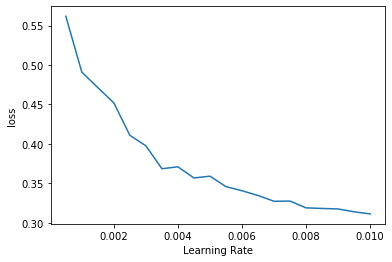

In [42]:
lrs = np.linspace(5e-4, 1e-2, 20, endpoint=True)
costs = []
for i in lrs:
    print(i)
    d = model(X_train, y_train, X_test, y_test, 500, i, False)
    costs.append(d['cost'])
plt.plot(lrs, costs)
plt.xlabel('Learning Rate')
plt.ylabel('loss')
plt.show()

##### 4.2 Observe the effect of iteration_num on the test accuracy.

训练轮次越多，正确率越高。
曲线图中产生的抖动猜测是w参数随机初始化的影响。

200
400
600
800
1000
1200
1400
1600
1800
2000


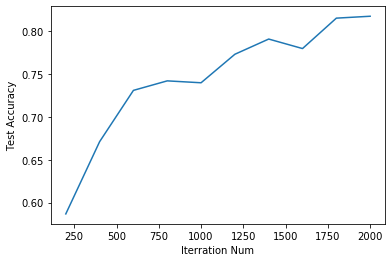

In [43]:
iters = np.linspace(200, 2000, 10, endpoint=True).astype(np.int)
accs = []
for i in iters:
    print(i)
    d = model(X_train, y_train, X_test, y_test, i, 1e-3, False)
    accs.append(d['test_accuracy'])
plt.plot(iters, accs)
plt.xlabel('Iterration Num')
plt.ylabel('Test Accuracy')
plt.show()

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

In [44]:
def initialize_parameters_2(dim1, dim2):

    w = np.random.random((dim1,dim2))
    b = np.zeros((dim2, 1))

    return w,b

def softmax(z):
    temp = np.exp(z)
    return temp/np.sum(temp, axis=0)

# 重写反向传播函数
def propagate_2(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    A = softmax(np.dot(w.T, X) + b)
    temp = Y * np.log(A) + (1 - Y) * np.log(1 - A)

    # 此处需要将二分类的损失函数改成多分类的损失函数
#     cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    cost = -1 / m * np.sum(Y * np.log(A))
    
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y, axis=(0,1))
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

def optimize_2(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    batch_size = 50
    for j in range(num_iterations):
        costs = []
        for i in range(0, X.shape[1], batch_size):
            X_ = X[:,i:i+batch_size]
            Y_ = Y[:,i:i+batch_size]

            grads, cost = propagate_2(w,b,X_,Y_)

            dw = grads['dw']
            db = grads['db']

            w -= learning_rate * dw
            b -= learning_rate * db

            costs.append(cost)
        
        cost = sum(costs)/len(costs)
        if print_cost and j % 100 == 0:
            print ("Cost after iteration %i: %f" %(j, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
     
    return params, grads, cost

def predict_2(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
#     w = w.reshape(X.shape[0],1)
    
    A = softmax(np.dot(w.T, X) + b)
    
    Y_prediction[0] = A.argmax(axis=0)
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

def model_2(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    
    # 参数初始化
    w, b = initialize_parameters_2(X_train.shape[0], Y_train.shape[0])
    
    # 训练模型
    params, grads, costs = optimize_2(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
            
    # 训练集精度
    Y_train_ = predict_2(w, b, X_train)
    traing_accuracy = np.mean(Y_train_ == np.expand_dims(Y_train.argmax(axis=0), axis=0))
           
    # 测试集
    Y_pre = predict_2(w, b, X_test)
    test_accuracy = np.mean(Y_pre == np.expand_dims(Y_test.argmax(axis=0), axis=0))
    
    d = {"w":w,
         "b":b,
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    
    return d

In [45]:
# 获取数据
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

# 数据预处理
# X标准化处理
X_train /= X_train.max()
X_test /= X_train.max()
# XY参数格式调整
X_train = X_train.T
y_train = np.eye(10)[y_train].T
X_test = X_test.T
y_test = np.eye(10)[y_test].T

In [46]:
d = model_2(X_train, y_train, X_test, y_test, 5000, 1e-2, True)
print(d)

Cost after iteration 0: 2.695583
Cost after iteration 100: 0.610572
Cost after iteration 200: 0.386751
Cost after iteration 300: 0.301874
Cost after iteration 400: 0.255266
Cost after iteration 500: 0.225094
Cost after iteration 600: 0.203648
Cost after iteration 700: 0.187448
Cost after iteration 800: 0.174671
Cost after iteration 900: 0.164267
Cost after iteration 1000: 0.155581
Cost after iteration 1100: 0.148184
Cost after iteration 1200: 0.141784
Cost after iteration 1300: 0.136171
Cost after iteration 1400: 0.131193
Cost after iteration 1500: 0.126735
Cost after iteration 1600: 0.122711
Cost after iteration 1700: 0.119053
Cost after iteration 1800: 0.115705
Cost after iteration 1900: 0.112625
Cost after iteration 2000: 0.109777
Cost after iteration 2100: 0.107133
Cost after iteration 2200: 0.104667
Cost after iteration 2300: 0.102360
Cost after iteration 2400: 0.100195
Cost after iteration 2500: 0.098156
Cost after iteration 2600: 0.096231
Cost after iteration 2700: 0.094409
Cost

In [47]:
# one-hot编码 
a = np.asarray([0,1,2,1,0])
b = np.eye(3)[a]
b

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

# Congratulations ! You have completed assigment 4. 